In [160]:
import torch 
import numpy as np
from scipy.sparse import csr_matrix

import pandas as pd
import scanpy as sc
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scvi.distributions import NegativeBinomial

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/scportrait_ot/src")
# sys.path.insert(0, "../nfs/homedirs/pala/scportrait_ot/src")

from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path
import matplotlib.pyplot as plt

## Check type of counts in the CITE seq RNA-seq version

In [161]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [162]:
adata

AnnData object with n_obs × n_vars = 42929 × 2000
    obs: 'barcode', 'donor_id', 'subproject', 'gem_id', 'assay', 'sex', 'age', 'age_group', 'hospital', 'nCount_RNA', 'nCount_ADT', 'nFeature_ADT', 'nFeature_RNA', 'pct_mt', 'pct_ribosomal', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'S.Score', 'G2M.Score', 'Phase', 'UMAP_1_20220215', 'UMAP_2_20220215', 'bcr_flag', 'tcr_flag', 'RNA.weight', 'ADT.weight', 'annotation_figure_1', 'annotation_prob', 'UMAP_1_level_1', 'UMAP_2_level_1'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_adt.umap', 'X_harmony_RNA', 'X_pca', 'X_rna.umap', 'X_wnn.umap'
    varm: 'HARMONY_RNA', 'PCs'
    obsp: 'distances'

In `.X` we have some form of normalization and scaling 

In [163]:
adata.X

array([[-0.19857288, -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082],
       [-0.19857288, -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082],
       [-0.19857288, -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082],
       ...,
       [ 6.9431813 , -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082],
       [-0.19857288, -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082],
       [-0.19857288, -0.02244474, -0.02245006, ..., -0.09576895,
        -0.01669313, -0.03966082]])

Check gene names 

In [164]:
adata.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable
ISG15,0.047287,0.060800,0.056220,1.081457,1
TNFRSF4,0.000559,0.000605,0.000584,1.035873,1
TAS1R1,0.000559,0.000605,0.000584,1.035873,1
UTS2,0.000326,0.000373,0.000335,1.113656,1
TNFRSF9,0.004426,0.009811,0.004872,2.013715,1
...,...,...,...,...,...
MT-CO1,16.488178,348.525024,248.929271,1.400097,1
AC233755.2,0.448368,184.273430,1.176818,36.291051,1
AC233755.1,0.086841,13.274466,0.111977,15.876514,1
AC136616.2,0.000676,0.004262,0.000709,2.280865,1


The rest is normalized and log-transformed 

In [165]:
adata.raw.X.max(1).todense()

matrix([[5.00004709],
        [5.76415739],
        [5.78143954],
        ...,
        [5.42771665],
        [6.1615999 ],
        [5.61112635]])

In [166]:
(np.exp(adata.raw.X.todense())-1).sum(1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

Options for reconstruction: 
* Unnormalized and negative binomial 
* Normalized and Gaussian 

Check the negative binomial assumption on unnormalized counts 

In [167]:
X_unnormalized = np.exp(adata.raw.X.toarray())-1

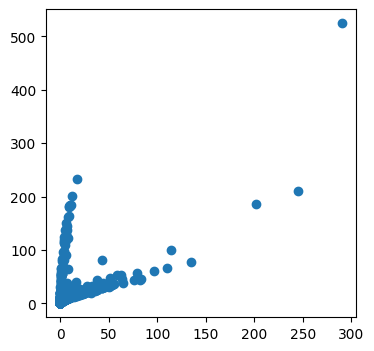

In [168]:
plt.figure(figsize=(4,4))
plt.scatter(X_unnormalized.mean(0), X_unnormalized.std(0))
plt.show()

In [169]:
X_unnormalized.mean(0).shape

(17288,)

## Prepare the adata and launch 

In [170]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


Log-norm

In [171]:
adata.layers["X_normalized_log"] = adata.raw[:, adata.var.index].X.copy()

In [172]:
adata.layers["X_normalized_log"].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.71894437, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

10k Norm

In [173]:
adata.layers["X_normalized_10k"] = csr_matrix(np.exp(adata.raw[:, adata.var.index].X.copy().toarray()) - 1)

In [174]:
adata.layers["X_normalized_10k"].todense().max(1)

matrix([[147.42014742],
        [317.67041694],
        [323.22559147],
        ...,
        [212.46458924],
        [473.18611987],
        [272.45206862]])

In [175]:
adata.layers["X_normalized_log"].todense().max(1)

matrix([[5.00004709],
        [5.76415739],
        [5.78143954],
        ...,
        [5.36347096],
        [6.1615999 ],
        [5.61112635]])

Save results

In [176]:
adata.write_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed.h5ad")

In [177]:
adata

AnnData object with n_obs × n_vars = 42929 × 2000
    obs: 'barcode', 'donor_id', 'subproject', 'gem_id', 'assay', 'sex', 'age', 'age_group', 'hospital', 'nCount_RNA', 'nCount_ADT', 'nFeature_ADT', 'nFeature_RNA', 'pct_mt', 'pct_ribosomal', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'S.Score', 'G2M.Score', 'Phase', 'UMAP_1_20220215', 'UMAP_2_20220215', 'bcr_flag', 'tcr_flag', 'RNA.weight', 'ADT.weight', 'annotation_figure_1', 'annotation_prob', 'UMAP_1_level_1', 'UMAP_2_level_1'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_adt.umap', 'X_harmony_RNA', 'X_pca', 'X_rna.umap', 'X_wnn.umap'
    varm: 'HARMONY_RNA', 'PCs'
    layers: 'X_normalized_log', 'X_normalized_10k'
    obsp: 'distances'

## Whole genome 

In [180]:
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [181]:
new_adata = sc.AnnData(X=csr_matrix(adata.raw.X.copy()), 
                      var=adata.raw.var.copy(), 
                      obs=adata.obs.copy(), 
                      obsm=adata.obsm.copy())

In [182]:
new_adata.layers['X_normalized_log'] = new_adata.X.copy()

In [183]:
new_adata.layers['X_normalized_10k'] = csr_matrix(np.exp(new_adata.X.toarray()) - 1)

In [184]:
new_adata.write_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed_full_genome.h5ad")

Check results

In [185]:
new_adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed_full_genome.h5ad")

In [191]:
new_adata.layers["X_normalized_10k"].toarray().max(1)

array([147.42014742, 317.67041694, 323.22559147, ..., 226.62889518,
       473.18611987, 272.45206862])

In [192]:
new_adata.layers["X_normalized_log"].toarray().max(1)

array([5.00004709, 5.76415739, 5.78143954, ..., 5.42771665, 6.1615999 ,
       5.61112635])